
# Weather-Aware Routing – Preprocessing, Scoring, and ML Model

This notebook:
1. Loads the combined dataset.
2. Preprocesses the data (cleaning, encoding, missing values).
3. Implements **Weather Sensitivity Scoring Logic**.
4. Performs basic EDA.
5. Trains and evaluates a Machine Learning model.


In [8]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv("Combined_Weather_Traffic_EV.csv")
print("Dataset shape:", df.shape)
df.head()


Dataset shape: (300, 57)


,InfrastructureID,RatePerHour,MaxTime,Latitude,Longitude,TAVG,PRCP,TMAX,TMIN,OBJECTID,...,TMIN_ATTRIBUTES,OBJECTID.2,OBJECTID.3,Label,Direction,SHAPE_Length,Year,PDF,geometry.2,geometry.3
0,PSP002216,Regular parking fees apply.,NaN,48.424600,-123.361093,26.3,0.0,38.4,18.2,19,...,",,a",19,1,450(92),both,8.000000,1992,NaN,POINT (-123.3638054044696 48.42511956618813),LINESTRING (-123.33190031062234 48.40990115042...
1,PSP002223,Free,NaN,48.446989,-123.334368,20.9,0.0,32.6,19.9,197,...,",,a",197,2,650(92),both,8.000040,1992,NaN,POINT (-123.33506163541432 48.44690464482426),LINESTRING (-123.33121562693142 48.41416665664...
2,PSP002225,Free,NaN,48.442372,-123.331238,17.3,0.0,21.8,15.3,430,...,",,a",430,3,370(87),both,7.999972,1987,NaN,POINT (-123.33499999346992 48.44683484227543),LINESTRING (-123.34398075493085 48.41359584867...
3,PSP000511,$3.00,90 MIN,48.422837,-123.367715,19.6,0.0,22.9,14.5,529,...,",,a",529,4,450(87),both,7.999988,1987,NaN,POINT (-123.36636785301413 48.425932381530174),LINESTRING (-123.34505607281409 48.41407090763...
4,PSP000629,$3.00,40 MIN,48.429492,-123.368619,22.2,0.0,30.1,15.8,778,...,",,a",778,5,280(87),both,7.999996,1987,NaN,POINT (-123.36964991148943 48.42796548598136),LINESTRING (-123.34501165382068 48.41496048523...


In [9]:
df = df.copy()  # make sure we're working on a real copy

num_cols = ['TMAX', 'TMIN', 'PRCP', 'Temp_Range']
for col in num_cols:
    if col in df.columns:
        # ensure numeric then fill
        s = pd.to_numeric(df[col], errors='coerce')
        df[col] = s.fillna(s.mean())

# Encode categorical variables (deterministic)
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].astype('category').cat.codes

In [10]:
# --- Scoring logic 

# 1) Ensure required columns exist and are numeric
for c in ["TMAX", "TMIN", "PRCP"]:
    if c not in df.columns:
        df[c] = 0
    df[c] = pd.to_numeric(df[c], errors="coerce").fillna(df[c].astype(float).mean())

# 2) Ensure Temp_Range exists
if "Temp_Range" not in df.columns:
    df["Temp_Range"] = df["TMAX"] - df["TMIN"]
df["Temp_Range"] = pd.to_numeric(df["Temp_Range"], errors="coerce").fillna(0)

# 3) Flags
df["High_Temp_Flag"] = (df["TMAX"] > 35).astype(int)
df["Low_Temp_Flag"]  = (df["TMIN"] < 5).astype(int)
df["No_Precip_Flag"] = (df["PRCP"] == 0).astype(int)

# 4) Temp range score (CREATE the column!)
def temp_range_score(x):
    if x > 20: return 1.0
    if x < 10: return 0.0
    return 0.5

df["Temp_Range_Score"] = df["Temp_Range"].apply(temp_range_score)

# 5) Final score
df["Weather_Sensitivity_Score"] = (
    2.0 * df["High_Temp_Flag"]
  + 1.5 * df["Low_Temp_Flag"]
  + 1.0 * (1 - df["No_Precip_Flag"])
  + df["Temp_Range_Score"]
)

# Optional: normalize to 0–1
df["Weather_Sensitivity_Score_Norm"] = (df["Weather_Sensitivity_Score"] / 5.0).round(3)

df[["TMAX","TMIN","PRCP","Temp_Range","Temp_Range_Score","Weather_Sensitivity_Score","Weather_Sensitivity_Score_Norm"]].head()


,TMAX,TMIN,PRCP,Temp_Range,Temp_Range_Score,Weather_Sensitivity_Score,Weather_Sensitivity_Score_Norm
0,38.4,18.2,0.0,20.2,1.0,3.0,0.6
1,32.6,19.9,0.0,12.7,0.5,0.5,0.1
2,21.8,15.3,0.0,6.5,0.0,0.0,0.0
3,22.9,14.5,0.0,8.4,0.0,0.0,0.0
4,30.1,15.8,0.0,14.3,0.5,0.5,0.1


       InfrastructureID  RatePerHour     MaxTime    Latitude   Longitude  \
count        300.000000   300.000000  300.000000  300.000000  300.000000   
mean          13.256667     1.893333   -0.196667   48.434801 -123.353294   
std            7.952038     1.188837    1.250280    0.010835    0.015769   
min            0.000000     0.000000   -1.000000   48.418847 -123.374624   
25%            7.000000     1.000000   -1.000000   48.425158 -123.366514   
50%           13.000000     2.000000   -1.000000   48.429905 -123.361679   
75%           20.000000     2.000000    1.000000   48.446401 -123.335721   
max           27.000000     4.000000    2.000000   48.452174 -123.329817   

             TAVG        PRCP        TMAX        TMIN     OBJECTID  ...  PDF  \
count  300.000000  300.000000  300.000000  300.000000   300.000000  ...  0.0   
mean    14.139333    1.762000   19.472000    9.680000  1386.586667  ...  NaN   
std      5.063997    4.790601    6.334189    4.694656   617.704286  ...  Na

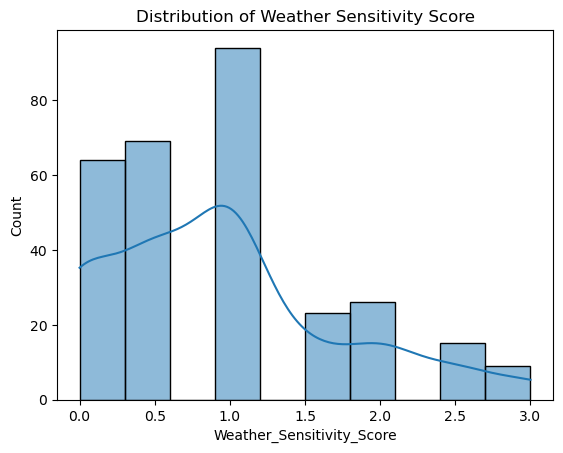

In [11]:
# Summary statistics
print(df.describe())

# Plot distribution of Weather Sensitivity Score
sns.histplot(df['Weather_Sensitivity_Score'], bins=10, kde=True)
plt.title("Distribution of Weather Sensitivity Score")
plt.show()


In [13]:
# Define the target variable
target_column = 'Weather_Sensitivity_Score'
print(f"Target variable: {target_column} — Predicting EV route weather sensitivity scores.")

# Separate features (X) and target (y)
X = df.drop(columns=[target_column])
y = df[target_column]

# Keep only numeric features
X = X.select_dtypes(include=[np.number])

# Show which features we are using
print("\nFeatures used for prediction:")
for col in X.columns:
    print(f" - {col}")

print(f"\nTotal features used: {len(X.columns)}")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"\nTraining samples: {len(X_train)}, Testing samples: {len(X_test)}")

# Train the model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate model performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nModel Evaluation:")
print(f" - Mean Squared Error (MSE): {mse:.4f}")
print(f" - R² Score: {r2:.4f}")

# Show a sample of predictions vs actual values
results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print("\nSample Predictions:")
print(results_df.head(10))


Target variable: Weather_Sensitivity_Score — Predicting EV route weather sensitivity scores.

Features used for prediction:
 - InfrastructureID
 - RatePerHour
 - MaxTime
 - Latitude
 - Longitude
 - TAVG
 - PRCP
 - TMAX
 - TMIN
 - OBJECTID
 - OBJECTID.1
 - Type
 - STYLE
 - MeterNumber
 - MapSymbol
 - Description
 - LifecycleStatus
 - Condition
 - HoursInEffect
 - Length_m
 - Width_m
 - AccessAisle
 - AccessAisleWidth_m
 - LoadingSide
 - DistanceToNearestLetdown_m
 - CrossSlope_percent
 - MeetsSDC16
 - NewSignageInstalled
 - CurbPainted
 - Location
 - CivicAddress
 - Comments
 - Owner
 - OwnerNotes
 - Custodian
 - CustodianNotes
 - geometry
 - geometry.1
 - STATION
 - NAME
 - LATITUDE
 - LONGITUDE
 - ELEVATION
 - DATE
 - PRCP_ATTRIBUTES
 - TAVG_ATTRIBUTES
 - TMAX_ATTRIBUTES
 - TMIN_ATTRIBUTES
 - OBJECTID.2
 - OBJECTID.3
 - Label
 - Direction
 - SHAPE_Length
 - Year
 - PDF
 - geometry.2
 - geometry.3
 - Temp_Range
 - High_Temp_Flag
 - Low_Temp_Flag
 - No_Precip_Flag
 - Temp_Range_Score
 -

In [14]:

df.to_csv("Processed_Combined_Weather_Traffic_EV_with_Score.csv", index=False)
print("Processed dataset saved as Processed_Combined_Weather_Traffic_EV_with_Score.csv")


Processed dataset saved as Processed_Combined_Weather_Traffic_EV_with_Score.csv
